<a href="https://colab.research.google.com/github/MichaelTj02/FinalProject_Group1/blob/main/CombinedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions and imports to run

In [1]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

In [2]:
# Function to capture license plate within the rider bounding box (for cases where there are multiple riders)
def is_within_bbox(inner_bbox, outer_bbox):
    x1, y1, x2, y2 = inner_bbox
    X1, Y1, X2, Y2 = outer_bbox
    return X1 <= x1 <= X2 and X1 <= x2 <= X2 and Y1 <= y1 <= Y2 and Y1 <= y2 <= Y2

In [70]:
def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Run the YOLO model with a lower confidence threshold
    results = helmet_model(image)

    # Iterate through detections
    for result in results[0].boxes.data.tolist():  # Extract detected bounding boxes
        x1, y1, x2, y2, confidence, class_id = result[:6]
        class_name = helmet_model.names[int(class_id)]  # Map class ID to label

        if class_name == "rider":
            rider_bbox = [x1, y1, x2, y2]

            # Check if the rider has the label "with helmet" or "without helmet"
            helmet_status = next(
                (
                    box for box in results[0].boxes.data.tolist()
                    if helmet_model.names[int(box[5])] in ["with helmet", "without helmet"]
                    and is_within_bbox(box[:4], rider_bbox)
                ),
                None,
            )

            if helmet_status:
                # Check the specific label for helmet status
                helmet_label = helmet_model.names[int(helmet_status[5])]
                if helmet_label == "with helmet":
                    print("Rider is wearing a helmet.")
                    continue  # Skip further processing for this rider
                elif helmet_label == "without helmet":
                    print("Rider is not wearing a helmet.")
            else:
                print("Helmet status could not be determined for this rider.")

            # Crop and show the rider who is not wearing a helmet
            rider_x1, rider_y1, rider_x2, rider_y2 = map(int, rider_bbox)
            cropped_rider = image[rider_y1:rider_y2, rider_x1:rider_x2]
            plt.imshow(cv2.cvtColor(cropped_rider, cv2.COLOR_BGR2RGB))
            plt.title("Rider without Helmet")
            plt.axis("off")
            plt.show()

            # Check for a license plate in the rider's bounding box
            license_plate = next(
                (
                    box for box in results[0].boxes.data.tolist()
                    if helmet_model.names[int(box[5])] == "number plate" and is_within_bbox(box[:4], rider_bbox)
                ),
                None,
            )

            if license_plate:
                # Crop the license plate from the image
                plate_x1, plate_y1, plate_x2, plate_y2 = map(int, license_plate[:4])
                cropped_plate = image[plate_y1:plate_y2, plate_x1:plate_x2]

                # Show the cropped license plate image
                plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
                plt.title("Cropped License Plate")
                plt.axis("off")
                plt.show()

                # Run the second YOLO model for character recognition
                plate_results = plate_model(cropped_plate)

                # Extract detected characters and their bounding boxes
                detected_chars = [
                    {
                        "char": plate_model.names[int(box[5])],  # Character label
                        "bbox": box[:4],  # Bounding box of the character
                    }
                    for box in plate_results[0].boxes.data.tolist()
                ]

                # Sort characters in reading order (top-left to bottom-right)
                sorted_chars = sort_characters(detected_chars)

                # Concatenate characters to form the license plate text
                license_plate_text = "".join(char["char"] for char in sorted_chars)

                # Output the result
                print(f"Rider without helmet. License plate text: {license_plate_text}")
            else:
                print("Rider without helmet, but no license plate detected. License plate text: Null.")

def sort_characters(detected_chars, y_threshold=10):

    # Sort by top (y1) coordinate first, useful for license plates that are formatted in two lines
    if not detected_chars:
        return []  # Return an empty list if no characters are detected

    # Sort by top (y1) coordinate first
    detected_chars = sorted(detected_chars, key=lambda c: c["bbox"][1])

    # Group characters into rows based on y_threshold
    rows = []
    current_row = [detected_chars[0]]
    for char in detected_chars[1:]:
        if abs(char["bbox"][1] - current_row[-1]["bbox"][1]) < y_threshold:
            current_row.append(char)
        else:
            rows.append(current_row)
            current_row = [char]
    rows.append(current_row)

    # Sort each row by left (x1) coordinate
    for row in rows:
        row.sort(key=lambda c: c["bbox"][0])

    # Flatten rows into a single list
    sorted_chars = [char for row in rows for char in row]
    return sorted_chars

# Combined model

In [38]:
# Load YOLOv8 models
helmet_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_Motorcycle\weights\best.pt")
plate_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_LicensePlate\weights\best.pt")

In [ ]:
# Load YOLOv8 models - Ryan
helmet_model = YOLO(r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Best_Motorcycle\weights\best.pt")
plate_model = YOLO(r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Best_LicensePlate\weights\best.pt")

In [55]:
# First image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new106.jpg"

In [ ]:
# First image prediction
image_path = r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new106.jpg"


0: 640x640 1 without helmet, 1 rider, 1 number plate, 30.8ms
Speed: 4.1ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Helmet status could not be determined for this rider.


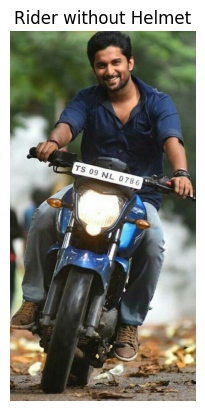

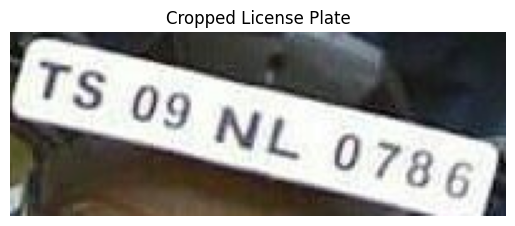


0: 256x640 1 L, 1 N, 1 T, 2 0s, 1 3, 1 6, 1 7, 1 8, 1 9, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)
Rider without helmet. License plate text: T309NL0786


In [56]:
process_image(image_path)

In [57]:
# Second image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new177.png"

In [ ]:
# Second image prediction
image_path = r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new197.jpg"


0: 448x640 1 without helmet, 1 rider, 24.0ms
Speed: 2.0ms preprocess, 24.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Rider is not wearing a helmet.


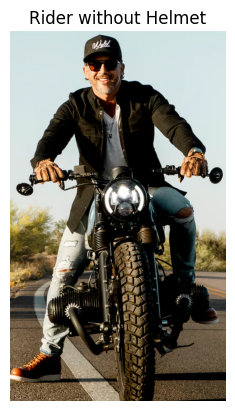

Rider without helmet, but no license plate detected. License plate text: Null.


In [58]:
process_image(image_path)

In [59]:
# Third image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new145.png"

In [ ]:
# Third image prediction
image_path = r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new191.png"


0: 640x544 1 with helmet, 1 rider, 1 number plate, 42.3ms
Speed: 3.0ms preprocess, 42.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)
Helmet status could not be determined for this rider.


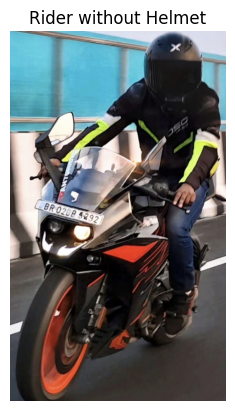

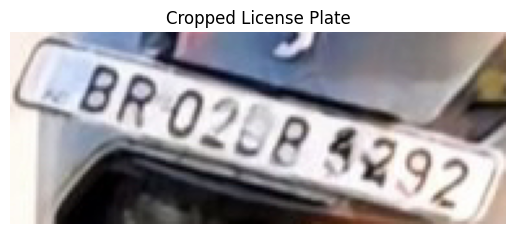


0: 256x640 2 Bs, 1 R, 1 0, 2 2s, 1 9, 7.0ms
Speed: 0.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)
Rider without helmet. License plate text: BR02B92


In [60]:
process_image(image_path)

In [61]:
# Fourth image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new0.jpg"

In [ ]:
# Fourth image prediction
image_path = r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new163.jpeg"


0: 640x576 2 without helmets, 1 rider, 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)
Rider is not wearing a helmet.


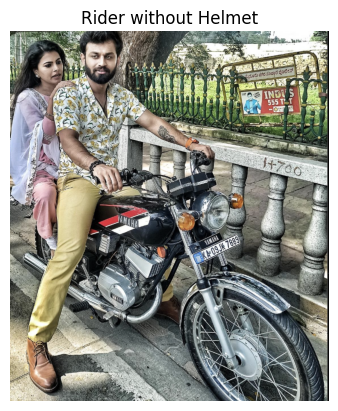

Rider without helmet, but no license plate detected. License plate text: Null.


In [62]:
process_image(image_path)

In [47]:
# Fifth image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new118.jpg"

In [ ]:
# Fifth image prediction
image_path = r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new118.jpg"


0: 640x320 1 without helmet, 1 rider, 1 number plate, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)
Helmet status could not be determined for this rider.


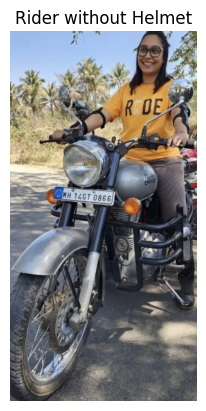

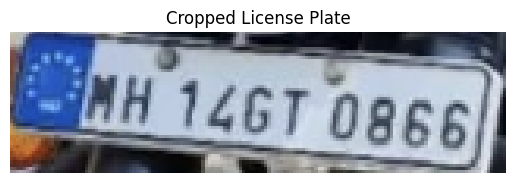


0: 192x640 1 G, 1 H, 1 M, 1 T, 1 0, 1 1, 1 4, 2 6s, 1 8, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)
Rider without helmet. License plate text: MH14GT0866


In [48]:
process_image(image_path)

In [63]:
# Sixth image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new119.jpg"

In [42]:
# Sixth image prediction
image_path = r"C:\Users\RyRyN\OneDrive\Documents\GitHub\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\train\new119.jpg"


0: 640x352 1 with helmet, 1 rider, 1 number plate, 27.9ms
Speed: 3.1ms preprocess, 27.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 352)
Helmet status could not be determined for this rider.


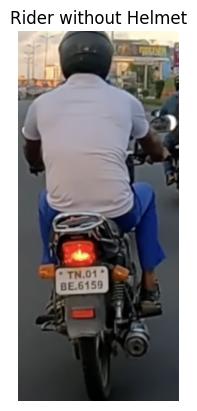

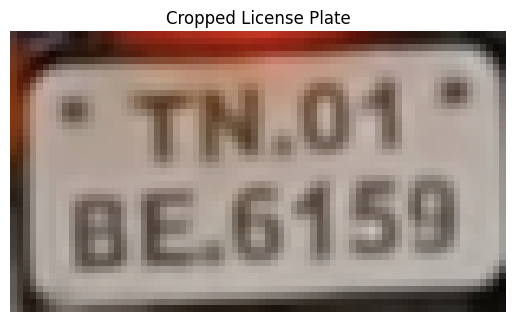


0: 384x640 1 H, 1 N, 1 T, 1 0, 2 1s, 1 5, 1 6, 1 9, 58.7ms
Speed: 1.0ms preprocess, 58.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Rider without helmet. License plate text: THN016159


In [64]:
process_image(image_path)

In [39]:
# Seventh image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new199.jpg"

In [40]:
process_image(image_path)


0: 480x640 1 with helmet, 1 rider, 10.1ms
Speed: 1.1ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Rider is wearing a helmet.


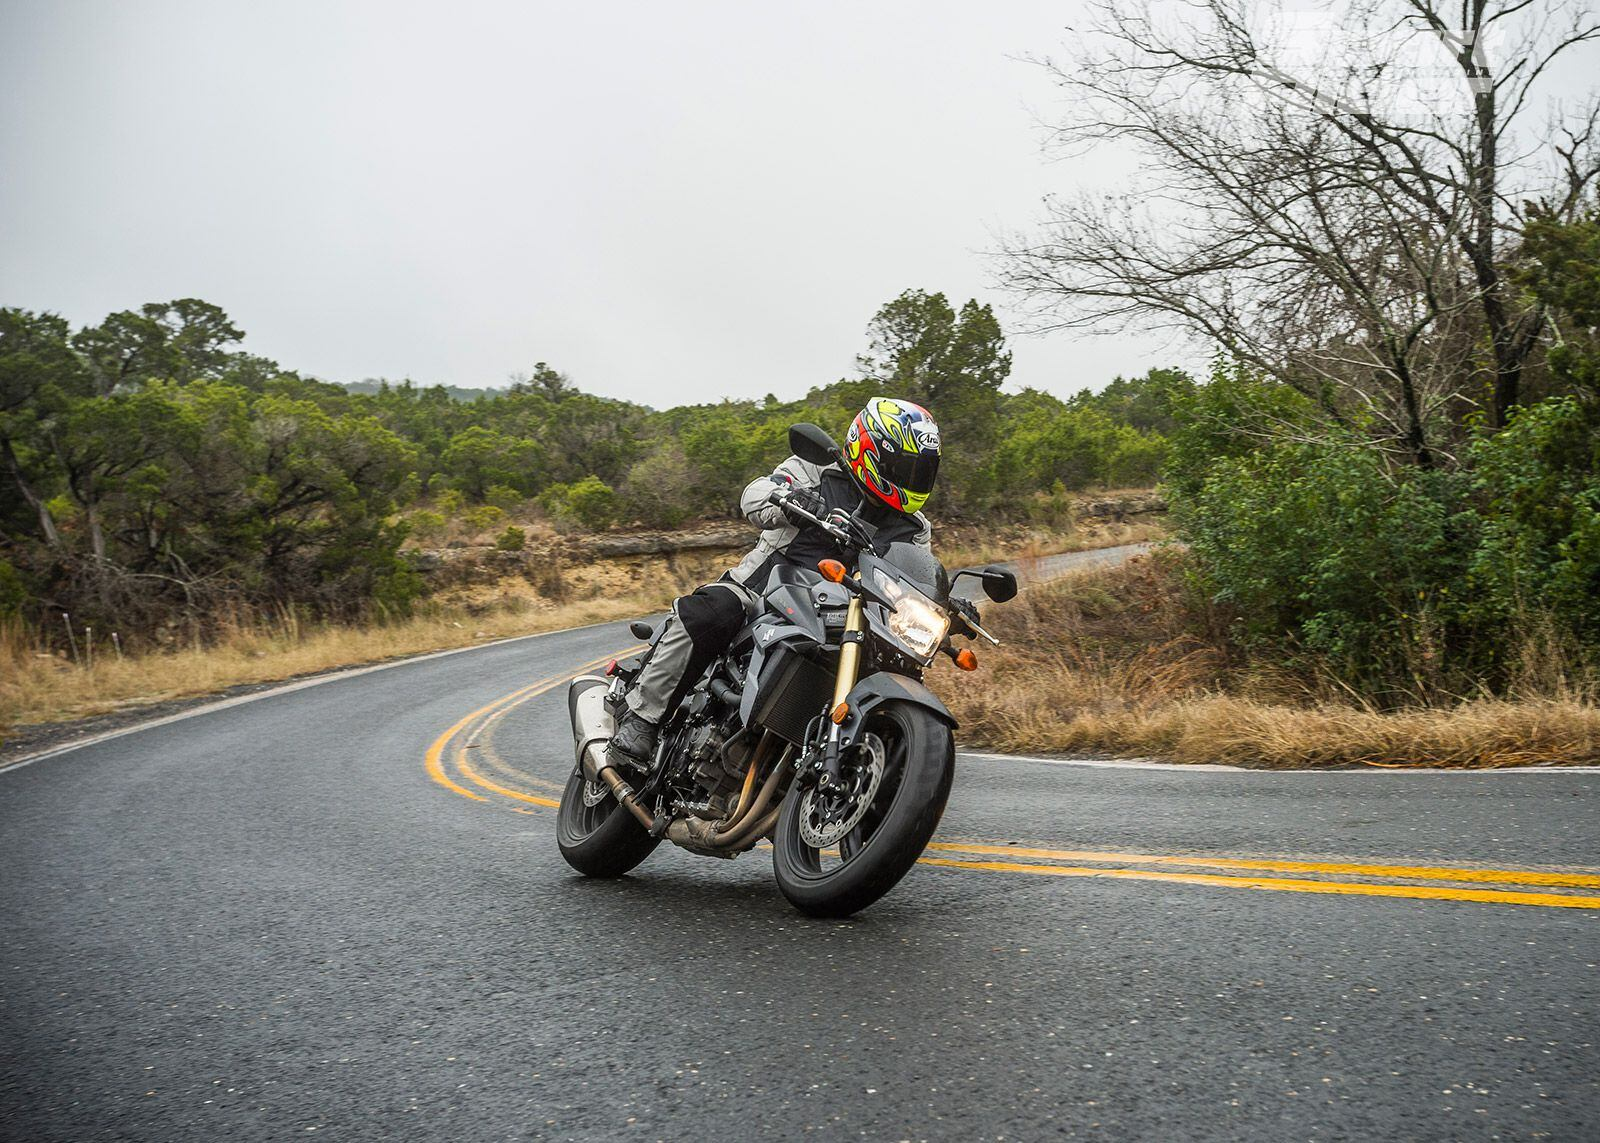

In [66]:
# To showcase the image that is being detected as wearing a helmet and does not capture the rider
%matplotlib inline
from PIL import Image

Image.open(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Datasets\MotorcycleHelmetDataset\images\val\new199.jpg")

In [68]:
# Eight image prediction
image_path = r"C:\Users\mtj02\Desktop\FinalProject_Group1\other files\IN23138.png"


0: 448x640 2 with helmets, 2 without helmets, 3 riders, 3 number plates, 32.4ms
Speed: 2.0ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Rider is wearing a helmet.
Helmet status could not be determined for this rider.


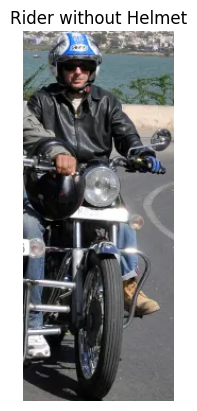

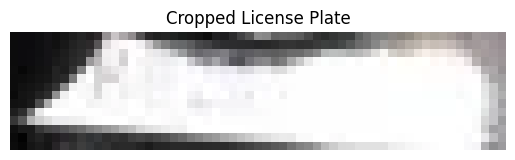


0: 160x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 160, 640)
Rider without helmet. License plate text: 
Rider is wearing a helmet.


In [71]:
process_image(image_path)

In [73]:
result = helmet_model(image_path, save = True)


image 1/1 C:\Users\mtj02\Desktop\FinalProject_Group1\other files\IN23138.png: 448x640 2 with helmets, 2 without helmets, 3 riders, 3 number plates, 26.3ms
Speed: 3.0ms preprocess, 26.3ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to C:\Users\mtj02\runs\detect\predict8


# API Testing

In [ ]:
from flask import Flask, request, jsonify
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt

app = Flask(__name__)

# Load YOLO models
helmet_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_MotorcycleModel\weights\best.pt")
plate_model = YOLO(r"C:\Users\mtj02\Desktop\FinalProject_Group1\Best_LicensePlateModel\weights\best.pt")

def is_within_bbox(inner_bbox, outer_bbox):
    x1, y1, x2, y2 = inner_bbox
    X1, Y1, X2, Y2 = outer_bbox
    return X1 <= x1 <= X2 and Y1 <= y1 <= Y2 and X1 <= x2 <= X2 and Y1 <= y2 <= Y2

@app.route('/process', methods=['POST'])
def process_image():
    # Check if an image is uploaded
    if 'image' not in request.files:
        return jsonify({'error': 'No image uploaded'}), 400

    # Save the uploaded image
    file = request.files['image']
    file_path = "./temp_image.jpg"
    file.save(file_path)

    # Load the image
    image = cv2.imread(file_path)

    # Run YOLO model for rider detection
    results = helmet_model(image)
    output_data = []

    for result in results[0].boxes.data.tolist():
        x1, y1, x2, y2, confidence, class_id = result[:6]
        class_name = helmet_model.names[int(class_id)]

        if class_name == "rider":
            rider_bbox = [x1, y1, x2, y2]

            # Check if the rider is wearing a helmet
            helmet_present = any(
                box for box in results[0].boxes.data.tolist()
                if helmet_model.names[int(box[5])] == "helmet" and is_within_bbox(box[:4], rider_bbox)
            )

            if helmet_present:
                output_data.append({"rider": "Helmet Detected", "license_plate": None})
                continue

            # Process rider without helmet
            license_plate = next(
                (
                    box for box in results[0].boxes.data.tolist()
                    if helmet_model.names[int(box[5])] == "number plate" and is_within_bbox(box[:4], rider_bbox)
                ),
                None,
            )

            if license_plate:
                # Crop the license plate and run the second model
                plate_x1, plate_y1, plate_x2, plate_y2 = map(int, license_plate[:4])
                cropped_plate = image[plate_y1:plate_y2, plate_x1:plate_x2]
                plate_results = plate_model(cropped_plate)

                detected_chars = [
                    {"char": plate_model.names[int(box[5])], "bbox": box[:4]}
                    for box in plate_results[0].boxes.data.tolist()
                ]
                sorted_chars = sorted(detected_chars, key=lambda c: (c["bbox"][1], c["bbox"][0]))
                license_plate_text = "".join(char["char"] for char in sorted_chars)

                output_data.append({"rider": "No Helmet", "license_plate": license_plate_text})
            else:
                output_data.append({"rider": "No Helmet", "license_plate": None})

    return jsonify(output_data)

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\mtj02\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
